# **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

import joblib

import warnings
warnings.filterwarnings('ignore')

# **Data Gathering**

In [2]:
tourism_df = pd.read_csv('../data/tourism_with_id.csv')

# **Data Cleaning**

In [3]:
tourism_df = tourism_df.drop(columns=['Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11', 'Unnamed: 12'])

# **Exploratory Data Analysis**

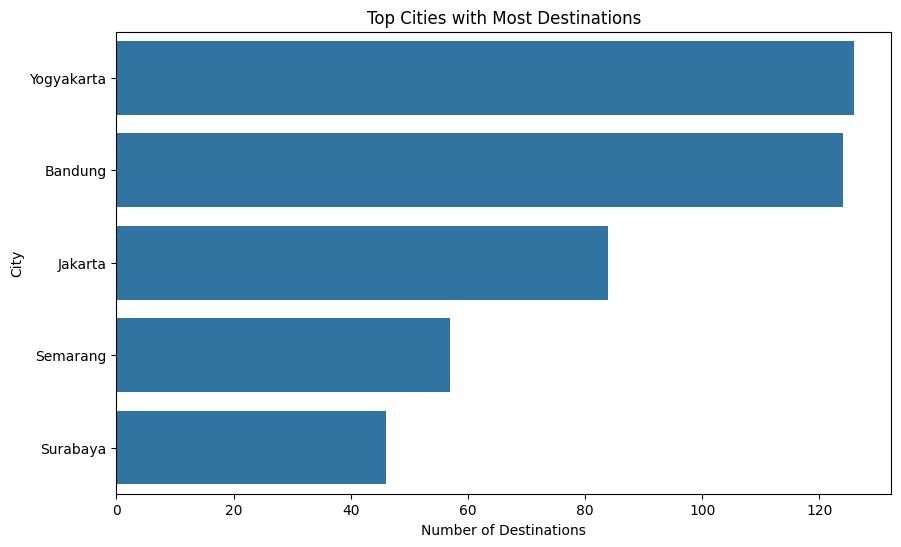

In [4]:
# 1. Top Cities with Most Destinations
city_count = tourism_df['City'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=city_count.values, y=city_count.index)
plt.title('Top Cities with Most Destinations')
plt.xlabel('Number of Destinations')
plt.ylabel('City')
plt.show()

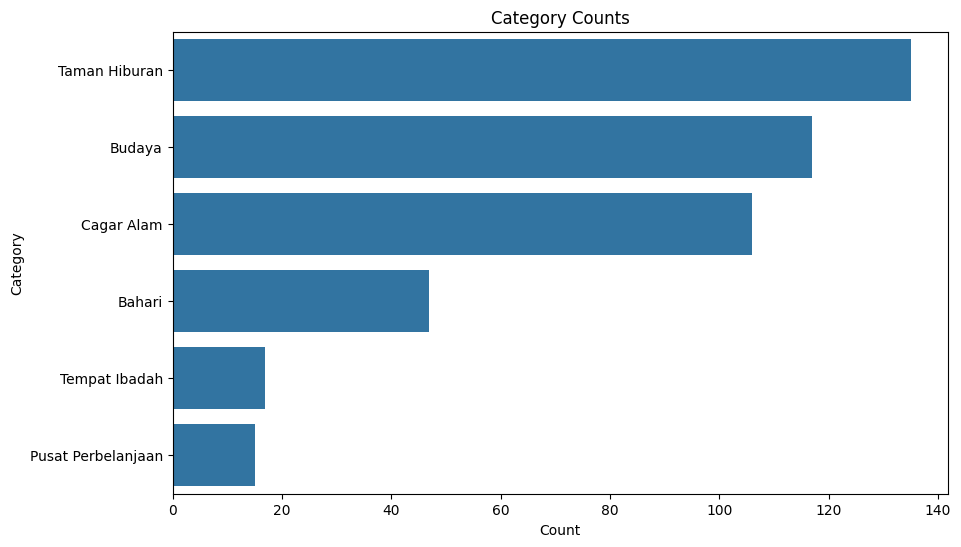

In [5]:
# 2. Category Counts
category_count = tourism_df['Category'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=category_count.values, y=category_count.index)
plt.title('Category Counts')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

 # **Content-Based Filtering Model**

### Data Preparation 

In [ ]:
def prepare_features(df):
    # Kombinasikan fitur
    df['combined_features'] = df.apply(lambda row: 
        f"{row['Place_Name']} {row['City']} {row['Description']}",
        axis=1
    )
    
    return df

### Data Augmentation

In [7]:
def augment_text(text, num_augmentations=2):
    augmented_texts = [text]
    
    # Tambahkan variasi dengan mengacak urutan kata
    words = text.split()
    for _ in range(num_augmentations):
        np.random.shuffle(words)
        augmented_texts.append(' '.join(words))
    
    return augmented_texts

### Data Processing

In [8]:
tourism_df = prepare_features(tourism_df)

In [9]:
# Augmentasi data
augmented_texts = []
augmented_categories = []

In [10]:
for idx, row in tourism_df.iterrows():
    augmented_versions = augment_text(row['combined_features'])
    augmented_texts.extend(augmented_versions)
    augmented_categories.extend([row['Category']] * len(augmented_versions))

In [11]:
# Konversi ke DataFrame
augmented_df = pd.DataFrame({
    'combined_features': augmented_texts,
    'Category': augmented_categories
})

In [12]:
# Proses TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(augmented_df['combined_features']).toarray()

In [13]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(augmented_df['Category'])
y_onehot = tf.keras.utils.to_categorical(y)

In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

In [15]:
# Normalisasi input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modeling

In [ ]:
# build model
def build_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Dense(512, input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),
        
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [17]:
# Inisialisasi dan compile model
input_dim = X_train_scaled.shape[1]
num_classes = y_train.shape[1]
model = build_model(input_dim, num_classes)

In [18]:
# Training
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
27/27 [==============================] - 4s 23ms/step - loss: 1.7253 - accuracy: 0.3449 - val_loss: 0.8199 - val_accuracy: 0.7905
Epoch 2/100
27/27 [==============================] - 0s 7ms/step - loss: 0.7051 - accuracy: 0.7959 - val_loss: 0.3536 - val_accuracy: 0.9238
Epoch 3/100
27/27 [==============================] - 0s 8ms/step - loss: 0.3311 - accuracy: 0.9284 - val_loss: 0.2022 - val_accuracy: 0.9524
Epoch 4/100
27/27 [==============================] - 0s 8ms/step - loss: 0.1894 - accuracy: 0.9654 - val_loss: 0.1575 - val_accuracy: 0.9524
Epoch 5/100
27/27 [==============================] - 0s 8ms/step - loss: 0.1118 - accuracy: 0.9869 - val_loss: 0.1293 - val_accuracy: 0.9429
Epoch 6/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0754 - accuracy: 0.9940 - val_loss: 0.1279 - val_accuracy: 0.9286
Epoch 7/100
27/27 [==============================] - 0s 9ms/step - loss: 0.0587 - accuracy: 0.9964 - val_loss: 0.1483 - val_accuracy: 0.9381
Epoch 8/100


In [ ]:
# Evaluasi
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

9/9 [==============================] - 0s 3ms/step - loss: 0.2052 - accuracy: 0.9506

Test accuracy: 0.9506


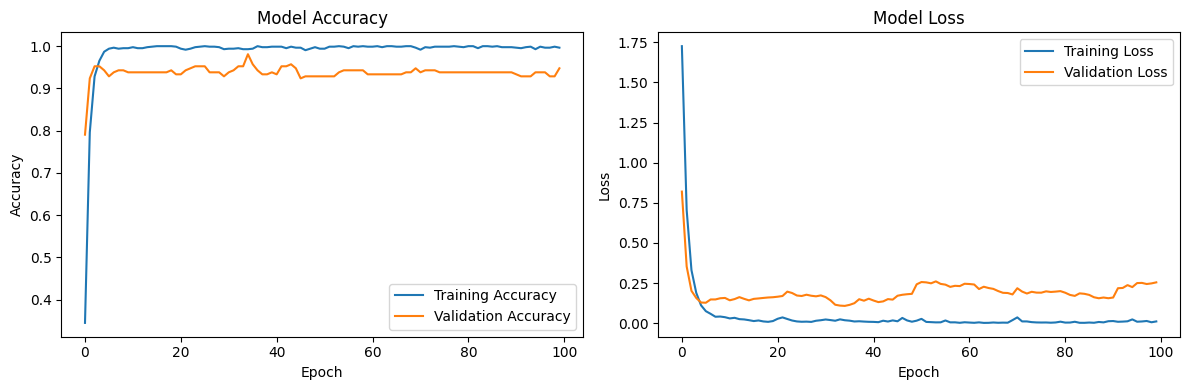

In [ ]:
# Plot hasil training
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


9/9 [==============================] - 0s 4ms/step


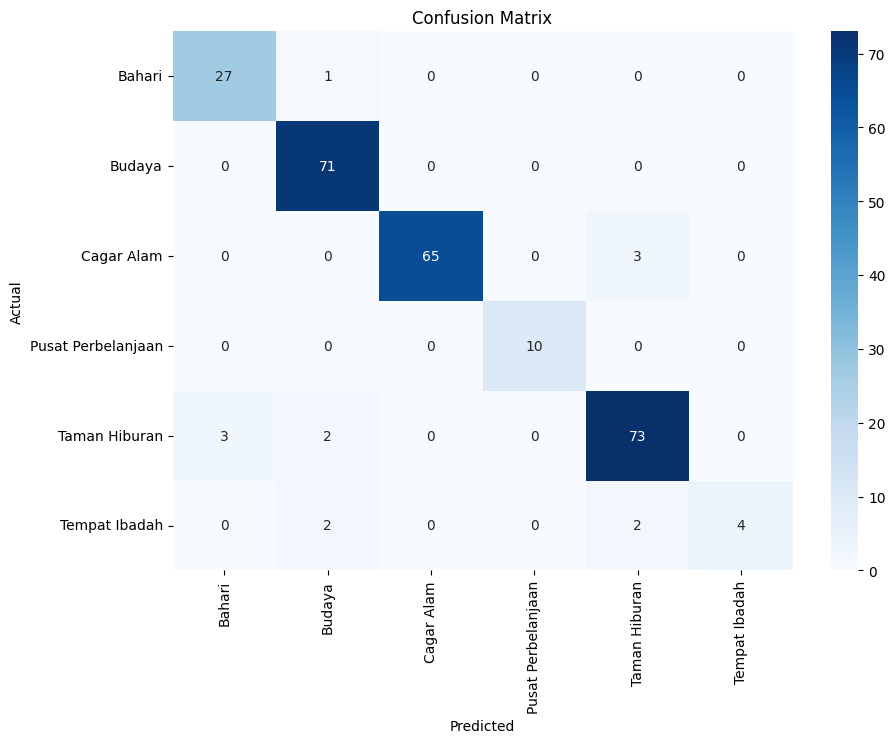

In [21]:
# Prediksi
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1) 

# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Menghitung jumlah prediksi benar dan salah
correct_predictions = np.sum(np.diag(conf_matrix))
total_predictions = np.sum(conf_matrix)
incorrect_predictions = total_predictions - correct_predictions

print(f"Total tempat wisata yang diprediksi: {total_predictions}")
print(f"Tempat wisata yang diprediksi dengan benar: {correct_predictions}")
print(f"Tempat wisata yang diprediksi salah: {incorrect_predictions}")

Total tempat wisata yang diprediksi: 263
Tempat wisata yang diprediksi dengan benar: 250
Tempat wisata yang diprediksi salah: 13


In [ ]:
def predict_category(model, tfidf_vectorizer, scaler, label_encoder, place_name):
    # Transformasi input menggunakan TF-IDF
    input_vector = tfidf_vectorizer.transform([place_name]).toarray()
    
    # Normalisasi input menggunakan scaler yang sama dengan training
    input_scaled = scaler.transform(input_vector)
    
    # Lakukan prediksi
    prediction = model.predict(input_scaled)
    
    # Dapatkan probabilitas untuk setiap kategori
    probabilities = prediction[0]
    predicted_category_index = np.argmax(probabilities)
    predicted_category = label_encoder.inverse_transform([predicted_category_index])[0]
    
    return predicted_category

In [61]:
# Contoh penggunaan:
input_place = "Kebun Binatang Ragunan"

predicted_category = predict_category(
    model=model,
    tfidf_vectorizer=tfidf_vectorizer,
    scaler=scaler,
    label_encoder=label_encoder,
    place_name=input_place,
)

print(f"\nFinal Prediction for {input_place}: {predicted_category}")

1/1 [==============================] - 0s 18ms/step

Final Prediction for Kebun Binatang Ragunan: Cagar Alam


# **Model Save**

In [ ]:
# Simpan model dalam format H5
# model.save('../model/tourism_classifier.h5')

In [ ]:
# Konversi ke TFLite untuk Android
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# with open('../model/tourism_classifier.tflite', 'wb') as f:
#     f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\LENOVO\AppData\Local\Temp\tmpkdo8aqg1\assets


In [ ]:
# simpan label encoder
# joblib.dump(label_encoder, '../model/label_encoder.joblib')

['../model/label_encoder.joblib']

In [ ]:
# simpan vectorizer
# joblib.dump(tfidf_vectorizer, '../model/tfidf_vectorizer.joblib')

['../model/tfidf_vectorizer.joblib']

In [ ]:
# simpan scaler
# joblib.dump(scaler, '../model/scaler.joblib')

['../model/scaler.joblib']